# CV第二次作业——SIFT算法实现（温都仁2017212534）
参考了文章<br>https://wenku.baidu.com/view/8ca23a5302d276a201292e66.html?rec_flag=default<br>
特征描述部分和极值检测部分偏移量计算参考了<br>https://www.csdn.net/gather_29/Mtjakg2sNTg4LWJsb2cO0O0O.html

In [1]:
import math
import numpy as np
from scipy import signal 
import PIL.Image as Image
import matplotlib.pyplot as plt

# 定义金字塔数据结构pyramid和每一层的节点Node
每个金字塔有唯一root节点，root节点有o个octave子节点;
每个octave节点有唯一父节点root和s+3个layer子节点;
每个layer字节点存放图像data和尺度sigmas;
getLayer(o,s)获取o组s层的信息，包含图像和sigma;

In [2]:
class Node:
    parent = None
    sigma = 0
    data = None
    children = []

    def __init__(self, parent, sigma, data):
        self.parent = parent
        self.sigma = sigma
        self.data = data
        self.children=[]
    
    def addChild(self, child):
        self.children.append(child)

    def getChild(self, child_n):
        return self.children[child_n]

class pyramid:
    root = None
    O = 0
    S = 0
    sigma0 = 0
    sigmalist = {}

    def __init__(self, sigma0, Octave_num, Layer_num = 3):
        self.O = Octave_num
        self.S = Layer_num
        self.sigma0 = sigma0
        self.root = Node(None, sigma0, None)

    def addOctave(self, o_):
        octave = Node(self.root, -1,o_)
        self.root.addChild(octave)

    def addLayer(self, sigma, o_, data):
        octave = self.root.getChild(o_)
        layer = Node(octave, sigma, data)
        octave.addChild(layer)
        self.sigmalist[sigma] = (o_, len(octave.children)-1)

    def getOctave(self, o_):
        return self.root.getChild(o_)

    def getLayer(self, o_, s_):
        layer = self.getOctave(o_).getChild(s_)
        return layer.data,layer.sigma
    
    def info(self):
        return self.O,self.S
    
    def getbysigma(self,sigma):
        o_,s_ = self.sigmalist[sigma]
        data = self.getOctave(o_).getChild(s_).data
        return data

# 第一步：构建高斯金字塔和高斯差分金字塔
（1）原图扩充为原来的两倍（双线性插值法）  <br>
（2）组数o=log2[min(M,N)]-3 ,层数s=3,s+3=6 <br>
（3）每一层的高斯模糊方差sigmas=sigma0×2**(si/s) <br>
<br>
在构建高斯金字塔和差分金字塔时先构造一层高斯金字塔，当s-1>=si>=1时同时构建差分金字塔

In [3]:
# 双线性插值法
def expand(img):
    if len(img.shape) == 2:
        M,N = img.shape
        res = np.zeros((M*2,N*2))
    else:
        M,N,depth = img.shape
        res = np.zeros((M*2,N*2))
    for x in range(M*2-1):
        for y in range(N*2-1):
            if x%2 == 0 and y%2 == 0:
                res[x][y] = img[int(x/2)][int(y/2)]
            elif x%2==0:
                res[x][y] = (img[int(x/2)][int((y-1)/2)]+img[int(x/2)][int((y+1)/2)])/2
            elif y%2==0:
                res[x][y] = (img[int((x-1)/2)][int(y/2)]+img[int((x+1)/2)][int(y/2)])/2
            else:
                res[x][y] = ((img[int((x-1)/2)][int((y-1)/2)]+img[int((x-1)/2)][int((y+1)/2)])/2+(img[int((x+1)/2)][int((y-1)/2)]+img[int((x+1)/2)][int((y+1)/2)])/2)/2
    return res

# 降采样
def down_sampling(img):
    M,N = img.shape
    if M%2!=0:
        M+=1
    if N%2!=0:
        N+=1
    res = np.zeros((int(M/2),int(N/2)))
    for x in range(M):
        for y in range(N):
            if x%2 == 0 and y%2 == 0:
                res[int(x/2)][int(y/2)] = img[x][y]
    return res

# 高斯模糊图像
def gaussian(img, sigma):
    sigma_a = int(6*sigma+1)
    M,N = img.shape
    
    gaussian = np.zeros((sigma_a,sigma_a))
    for i in range(sigma_a):
        for j in range(sigma_a):
            gaussian[i][j] = np.exp(-((i-int(sigma_a/2))**2+(j-int(sigma_a/2))**2)/(2*sigma**2))/(2*math.pi*sigma**2)
    res = signal.convolve2d(img, gaussian, boundary='symm',mode='same')
    return res

# 构建金字塔
def get_gaussian_pyramid(img, sigma0, s_ = 3):
    M,N = img.shape
    init = int(M/2)
    o_ = int((math.log(min(M,N),2))-3)
    s_ += 3
    k=2**(1/s_)
    gaussian_ = pyramid(sigma0, o_, s_)
    diffrence_ = pyramid(sigma0, o_, s_-1)
    
    for o in range(o_):
        if o!=0:
            img = down_sampling(img)
            M = int(M/2)
            N = int(N/2)
        gaussian_.addOctave(o-1)
        diffrence_.addOctave(o-1)
        for s in range(s_):
            sigma = sigma0 * 2 ** ((o-1)+s/s_)
            LoG = gaussian(img, sigma)
            gaussian_.addLayer(sigma, o, LoG)
            if s>0:
                LoGk,sigmak = gaussian_.getLayer(o, s-1)
                DoG = LoG - LoGk
                diffrence_.addLayer(sigmak, o, DoG)
    return diffrence_,gaussian_

# 第二步：求取极值点
（1）每个像素和它周围的26点比较判断是否为极值点 <br>
（2）若是，则计算其偏移量，小于0.5时保留，共迭代5次，五次无法达到要求时不取<br>
（3）去除低对比度点  阈值0.03<br>
（4）去除边缘响应,满足tr（H）/det（H）<12.1时保留<br>

In [4]:
# 判断当前点是否为极值点
def is_extreme(kf,kb,k):
    target=k[1,1]
    if target>np.max(kf) and target>np.max(kb):
        for i in range(3):
            for j in range(3):
                if i==1 and j==1:
                    continue
                if k[i][j]>=target:
                    return False
    elif target<np.min(kf) and target<np.min(kb):
        for i in range(3):
            for j in range(3):
                if i==1 and j==1:
                    continue
                if k[i][j]<=target:
                    return False
    return True

# 一阶导矩阵
def deriv3d(diff,x,y,o,s):
    kf = diff.getLayer(o, s-1)[0]
    k= diff.getLayer(o,s)[0]
    kb = diff.getLayer(o, s+1)[0]
    
    dx = (k[x][y+1]-k[x][y-1])/2
    dy = (k[x+1][y]-k[x-1][y])/2
    ds = (kb[x][y]-kf[x][y])/2
    dl = np.matrix([[dx],[dy],[ds]])
    
    return dl

# 海森矩阵
def hessian3d(diff,x,y,o,s):
    kf = diff.getLayer(o, s-1)[0]
    k= diff.getLayer(o,s)[0]
    kb = diff.getLayer(o, s+1)[0]
    
    dxx = k[x][y+1]-2*k[x][y]+k[x][y-1]
    dyy = k[x+1][y]-2*k[x][y]+k[x-1][y] 
    dss = kb[x][y]-2*k[x][y]+kf[x][y]
    dxy = (k[x+1][y+1]-k[x+1][y-1]-k[x-1][y+1]+k[x-1][y-1])/4
    dxs = (kb[x,y+1]-kb[x][y-1]-kf[x][y+1]+kf[x][y-1])/4
    dys = (kb[x+1][y]-kb[x-1][y]-kf[x+1][y]+kf[x-1][y])/4
    
    H = np.matrix([[dxx,dxy,dxs],[dxy,dyy,dys],[dxs,dys,dss]])
    
    return H
    
# 偏移量计算          
def calc_shifting(diff,x,y,o,s):
    dD = deriv3d(diff,x,y,o,s)
    H = hessian3d(diff,x,y,o,s)
    
    H_inv = H.I * -1
    X = H_inv * dD
    
    return X[0],X[1],X[2]
    
def low_contr(diff,x,y,o,s,contr_th):
    image = diff.getLayer(o,s)[0]
    if image[x][y]<contr_th:
        return True
    return False
    
#偏移+低对比度去除，输入极值点x,y,octave,layer，返回x,y,c方向上的偏移量
def interp(diff,x,y,o,s,contr_th=0.03):
    o_,s_ = diff.info()
    M,N = diff.getLayer(o,s)[0].shape
    xr,xc,xs = 0,0,0
    for i in range(5):
        xr,xc,xs = calc_shifting(diff,x,y,o,s)
        xr = xr[0,0]
        xc = xc[0,0]
        xs = xs[0,0]
        if(abs(xr)<0.5 or abs(xc)<0.5 or abs(xs)<0.5):
            break
        else:
            if(i==4):
                return -1
        x+=int(round(xr,0))
        y+=int(round(xc,0))
        s+=int(round(xs,0))
        if(x<1 or y<1 or s<1 or x>M-2 or y>N-2 or s>s_-2):
            return -1
    if (low_contr(diff,x,y,o,s,contr_th)):
        return -1
    return xr,xc,xs

# 边缘响应去除
def not_edge_like(k, x, y, th=1.7):
    dxx = k[x][y+1]-2*k[x][y]+k[x][y-1]
    dyy = k[x+1][y]-2*k[x][y]+k[x-1][y] 
    dxy = (k[x+1][y+1]-k[x+1][y-1]-k[x-1][y+1]+k[x-1][y-1])/4
    tr = dxx+dyy
    det = dxx*dyy - dxy**2
    
    if det<=0:
        return False
    if (tr**2/det)<((th+1)**2/th):
        return True
    return False

#输入高斯差分金字塔，输出特征列表，特征列表格式[对应0组的特征点位置,所在层的位置信息和尺度偏移量, 主方向，辅方向]
def get_peak(diff,contr_th,edge_th):
    octave_,layer_ = diff.info()
    res = np.zeros((0,4))
    for o in range(octave_):
        M,N = diff.getLayer(o,0)[0].shape
        for s in range(1,layer_-1):
            kf = diff.getLayer(o, s-1)[0]
            k,sigma = diff.getLayer(o,s)
            kb = diff.getLayer(o, s+1)[0]
            
            for x in range(1,M-1):
                for y in range(1,N-1):
                    if k[x][y]>0.03:
                        is_peak = is_extreme(kf[x-1:x+2,y-1:y+2],kb[x-1:x+2,y-1:y+2],k[x-1:x+2,y-1:y+2])
                        if is_peak:
                            shift = interp(diff,x,y,o,s,contr_th)
                            if shift== -1:
                                
                                break
                            if not_edge_like(k, x, y, edge_th):
                                ptx = int(round((x+shift[0])*2**(o-1),0))
                                pty = int(round((y+shift[1])*2**(o-1),0))
                                if ptx<0 or pty<0:
                                    break
                                res = np.append(res,[[(ptx,pty),(x,y,o,s,shift[2]),-1,-1]],axis=0)
    return res

# 第三步：关键点方向匹配
（1）求取关键点周围16个像素点的36点方向直方图并进行高斯平滑[0.25,0.5,0.25] <br>
（2）取方向直方图能量最高的方向为主方向，大于主方向80%的为辅方向

In [5]:
# 直方图平滑
def histogram_smoothing(hist):
    res = np.zeros((36))
    res[0] = hist[0]*0.5+hist[1]*0.25
    res[35] = hist[34]*0.25+hist[35]*0.5
    for i in range(1,35):
        res[i] = hist[i-1]*0.25+hist[i]*0.5+hist[i+1]*0.25
    return res

# 梯度计算
def calc_grad(image, x, y):
    M,N = image.shape
    if x<1 or y<1 or x>M-2 or y>N-2:
        return -1
    dx = (image[x][y+1]-image[x][y-1])/2
    dy = (image[x-1][y]-image[x+1][y])/2
    if dx==0:
        return -1
    mag = math.sqrt(dx**2+dy**2)
    phase = math.atan(dy/dx)
    return mag,phase

# 计算直方图+高斯加权
def get_grad_hist(image,x,y,sigma,rad=8,bin_num=36,smooth_time=2):
    hist = np.zeros((bin_num))
    exp_ = 2*sigma**2
    for i in range(-rad,rad):
        for j in range(-rad,rad):
            grad = calc_grad(image,i+x,j+y)
            if grad==-1:
                continue
            weight = np.exp(-(i**2+j**2)/exp_)
            bin_ = int(round(bin_num*(grad[1]+math.pi)/(math.pi*2),0))
            bin_ = 0 if bin_<0 else bin_
            hist[bin_] += weight*grad[0]
    for i in range(smooth_time):
        hist = histogram_smoothing(hist)
    return hist

# 主方向选取
def main_directions_matching(features,diff, sigma_init =  1.6, sigma_pre=0.5):
    size,tmp = features.shape
    init,tmp = diff.getLayer(0,0)[0].shape
    for i in range(size):
        x,y,o,s,tmp = features[i][1]
        image = diff.getLayer(o,s)[0]
        M,N = image.shape
        sigma = round(math.sqrt(sigma_init**2 - (sigma_pre*(M/init))**2),2)
        hist = get_grad_hist(image,x,y,sigma)
        main_dir = np.argmax(hist)
        main80 = hist[main_dir]*0.8
        tmp = np.where(hist>=main80)
        sec_dir = np.max(tmp)
        features[i][2] = (main_dir*10,hist[main_dir])
        features[i][3] = (sec_dir*10,hist[sec_dir])
        
    return features

# 第四步：特征描述
（1）选取特征点周围半径为r的区域，将其划分为d×d的子区域 <br>
（2）旋转坐标轴，用插值法计算一个点对周围行/列/尺度的贡献权重 <br>
（3）展开直方图得到128维的向量

In [6]:
def weight(hist,x_bin,y_bin,o_bin,w,d,n):
    x0 = int(x_bin)
    y0 = int(y_bin)
    o0 = int(o_bin)
    dr = x_bin-x0
    dc = y_bin-y0
    do = o_bin-o0
    
    k=1 if dr!=0 else 0
    m=1 if dc!=0 else 0
    n=1 if do!=0 else 0
    
    weight = w*dr**k*(1-dr)**(1-k)*dc**m*(1-dc)**(1-m)*do**n*(1-do)**(1-n)
    hist[x0][y0][o0%n]+=weight
    return hist

def dec_hist(gaus,x,y,o,s,theta,d,sigma,n=8):
    hist = np.zeros((d,d,n))
    cos_ = math.cos(theta)
    sin_ = math.sin(theta)
    bin_ = n/math.pi*2 # 每rad多少n
    exp_ = d**2/2
    r = int((sigma*3*math.sqrt(2)*(d+1))/2)
    img = gaus.getLayer(o,s)[0]
    for i in range(-r,r):
        for j in range(-r,r):
            #x'y'
            x_rot = (i*cos_ - j*sin_)
            y_rot = (i*sin_ + j*cos_)
            #x'' y''
            x_bin = x_rot/(3*sigma)+d/2
            y_bin = y_rot/(3*sigma)+d/2
            
            if (x_bin>-1 and x_bin<d and y_bin>-1 and y_bin<d):
                grad = calc_grad(img, x+i, y+j)
                if grad==-1:
                    continue
                mag, phase = grad
                phase -= theta #旋转后的rad
                while phase<0:
                    phase += math.pi*2
                while phase>2*math.pi:
                    phase -= math.pi*2
                o_bin = phase * bin_
                w = np.exp(-(x_rot**2+y_rot**2)/(2*sigma**2))*mag
                hist=weight(hist,x_bin,y_bin,o_bin,w,d,n)
    return hist

def normalize_descr(descr):
    sq = np.sum(np.sqrt(descr))
    inv = 1/sq
    descr *= inv
    return descr
    

def hist2descr(hist,d,feature,n=8):
    temp=np.zeros((0))
    for x in range(d):
        for y in range(d):
            for o in range(n):
                temp = np.append(temp,hist[x][y][o])
    temp = normalize_descr(temp)
    for i in range(len(temp)):
        if temp[i]>0.2:
            temp[i]=0.2
    res = normalize_descr(temp)
    return res
                
def description(features,gaus,sigma_init,sigma_pre=0.5,d=4):
    init,tmp = gaus.getLayer(1,0)[0].shape
    descr = np.zeros((0,128))
    for feature in features:
        x,y,o,s,shift = feature[1]
        theta,m = feature[2]
        M,N=gaus.getLayer(o,s)[0].shape
        sigma = round(math.sqrt(sigma_init**2 - (sigma_pre*(M/init))**2),2)
        hist = dec_hist(gaus,x,y,o,s,theta,d,sigma)
        des = hist2descr(hist,d,feature)
        descr=np.append(descr,[des],axis=0)
    return descr

### SIFT(img,sigma_init=1.6,sigma_pre=0.5,contr_th=0.03,edge_th=1.5)
输入:图像img（灰度）<br>
可选参数：初始尺度sigma_init 默认1.6<br>
&ensp;&ensp;&ensp;&ensp;&ensp;相机模糊尺度sigma_pre 默认0.5<br>
&ensp;&ensp;&ensp;&ensp;&ensp;对比度阈值contr_th 默认0.03<br>
&ensp;&ensp;&ensp;&ensp;&ensp;边缘响应去除阈值edge_th 理论上取10<br>
输出:((特征点位置，特征点方向)，特征向量）<br>
<br>
部分图片可能出现海森矩阵求逆出现inf NaN的问题

In [7]:
def SIFT(img,sigma_init=1.6,contr_th=0.03,edge_th=1.8):
    imgl = expand(img_np)
    diff,gaus = get_gaussian_pyramid(imgl, sigma_init)
    features = get_peak(diff,contr_th,edge_th)
    features = main_directions_matching(features,diff,sigma_init)
    descr = description(features,gaus,1.6)
    return (features[:,0],features[:,2]),descr

In [8]:
img=Image.open("front.jpg").convert('L')
img_np = np.asarray(img)
img_np = img_np/255
feature,descr = SIFT(img_np)

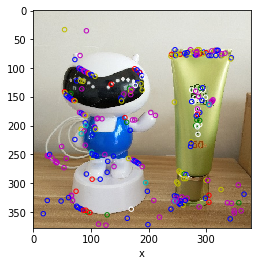

In [9]:
igm = Image.open('front.jpg')
igm = np.asarray(igm)/255
plt.imshow(igm)
colormap = ['c','m','b','y','r','g','b','w']
for i in range(len(feature[0])):
    x,y = feature[0][i]
    theta,m = feature[1][i]
    m*=100
    c = colormap[int(m if m<8 else 7)][0]
    plt.scatter(y,x,color='',edgecolor=c,marker='o',s=20)
plt.xlabel('x')
plt.show()

In [10]:
import cv2

imgname1 = 'front.jpg'

sift = cv2.xfeatures2d.SIFT_create()

img1 = cv2.imread(imgname1)
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) #灰度处理图像
kp1, des1 = sift.detectAndCompute(img1,None)   #des是描述子

out=np.zeros(img1.shape)
out=cv2.drawKeypoints(img1,kp1,out,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(out)

ModuleNotFoundError: No module named 'cv2'

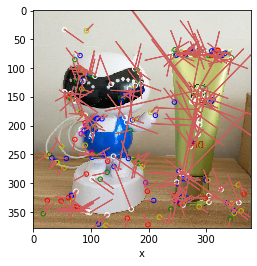

In [17]:
igm = Image.open('front.jpg')
igm = np.asarray(igm)/255
plt.imshow(igm)
colormap = ['c','m','b','y','r','g','b','w']
for i in range(len(feature[0])):
    x,y = feature[0][i]
    theta,m = feature[1][i]
    m*=200
    c = colormap[int(m if m<8 else 7)][0]
    plt.scatter(y,x,color='',edgecolor=c,marker='o',s=20)
    plt.arrow(y,x,5*m*math.cos(theta),5*m*math.sin(theta), width=m/50,color='#CD5C5C')
plt.xlabel('x')
plt.show()